# Homework 6 Question 1: The Huber Loss
In statistics, we frequently encounter data sets containing outliers, which
are bad data points arising from experimental error or abnormally high noise. Consider for example
the following data set consisting of 15 pairs $(x, y)$.

| | | | | | | | | | | | | | | |
--- |--- |--- |--- |--- |--- |--- |--- |--- |--- |--- |--- |--- |--- |--- |---
x |1 |2 |3 |4 |5 |6 |7 |8 |9 |10 |11 |12 |13 |14 |15
y |6.31 |3.78 |24 |1.71 |2.99 |4.53 |2.11 |3.88 |4.67 |4.25 |2.06 |23 |1.58 |2.17 |0.02

The y values corresponding to $x = 3$ and $x = 12$ are outliers because they are far outside the expected
range of values for the experiment.

__a) Compute the best linear fit to the data using an__ $\ell_2$ __cost (least squares). In other words, we are
looking for the a and b that minimize the expression:__

$$
        \ell_2\space cost: \sum_{i=1}^{15}(y_i - ax_i -b)^2
$$
__Repeat the linear fit computation but this time exclude the outliers from your data set. On a
single plot, show the data points and both linear fits. Explain the difference between both fits.__

In [1]:
x = linspace(1,15,15)
y = [6.31 3.78 24 1.71 2.99 4.53 2.11 3.88 4.67 4.25 2.06 23 1.58 2.17 0.02]';

### Least Squares

In [2]:
# order of polynomial to use 
k=1
# fit using a function of the form f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}
n = length(x)
A = zeros(n,k+1)
for i = 1:n
    for j = 1:k+1
        A[i,j] = x[i]^(k+1-j)
    end
end

In [3]:
using JuMP, Gurobi
import JuMP: GenericAffExpr

# helper function defined to model linear constraints for absolute value in JuMP for array variables
function abs_array{V<:GenericAffExpr}(v::Array{V})
    m = first(first(v).vars).m
    @variable(m, aux[1:length(v)] >= 0)
    @constraint(m, aux .>= v)
    @constraint(m, aux .>= -v)
    return aux
end;

In [4]:

m = Model(solver=GurobiSolver(OutputFlag=0))
@variable(m, u[1:k+1])
@objective(m, Min, sum((y - A*u).^2))

status = solve(m)
uopt = getvalue(u)
println(status)
println("L2 Error: ",norm(y - A*uopt),
    " Objective value: ",getobjectivevalue(m),", Parameters learnt: ", uopt)

Optimal
L2 Error: 27.08033949460119 Objective value: 733.3447871428841, Parameters learnt: [-0.290786,8.13029]


#### Plot

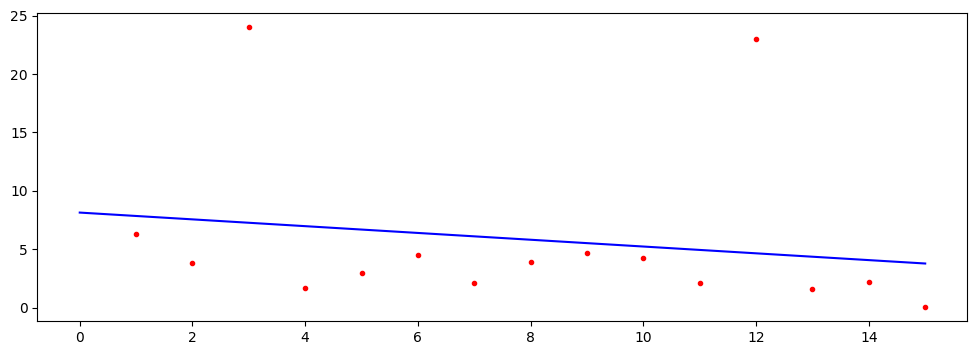

In [5]:
using PyPlot
npts = 100
xfine = linspace(0,15,npts)
ffine = ones(npts)
for j = 1:k
    ffine = [ffine.*xfine ones(npts)] 
end
yfine = ffine * uopt

figure(figsize=(12,4))
plot( x, y, "r.")
plot( xfine, yfine, "b-");

Cleaning the data by removing the enrty of $x=3$ and $x=12$

In [6]:
x_clean = [1 2 4 5 6 7 8 9 10 11 13 14 15]
y_clean = [6.31 3.78 1.71 2.99 4.53 2.11 3.88 4.67 4.25 2.06 1.58 2.17 0.02]';

### Least Squares

In [7]:
# order of polynomial to use 
k=1
# fit using a function of the form f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}
n_clean = length(x_clean)
A_clean = zeros(n_clean,k+1)
for i = 1:n_clean
    for j = 1:k+1
        A_clean[i,j] = x_clean[i]^(k+1-j)
    end
end


In [8]:
m = Model(solver=GurobiSolver(OutputFlag=0))
@variable(m, u[1:k+1])
@objective(m, Min, sum((y_clean - A_clean*u).^2))

status = solve(m)
uopt_clean = getvalue(u)
println(status)
println("L2 Error: ",norm(y_clean - A_clean*uopt_clean),
    " Objective value: ",getobjectivevalue(m),", Parameters learnt: ", uopt_clean)

Optimal
L2 Error: 4.528647342002823 Objective value: 20.508646748243223, Parameters learnt: [-0.236484,4.9916]


#### Plot

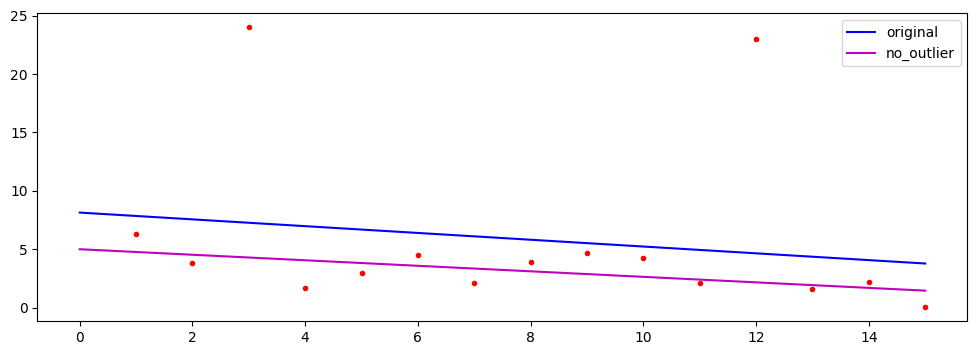

In [9]:
using PyPlot
npts = 100
xfine = linspace(0,15,npts)
ffine = ones(npts)
for j = 1:k
    ffine = [ffine.*xfine ones(npts)] 
end
yfine = ffine * uopt

xfine_clean = linspace(0,15,npts)
ffine_clean = ones(npts)
for j = 1:k
    ffine_clean = [ffine_clean.*xfine_clean ones(npts)] 
end
yfine_clean = ffine_clean * uopt_clean

figure(figsize=(12,4))
plot( x, y, "r.")
plot( xfine, yfine, "b-",label="original");
plot( xfine_clean, yfine_clean, "m-", label="no_outlier")
legend();

The difference between the two lines can be explained by the fact that the model for the clean data doesn't try to minmize the cost which it incurs due to the outliers which is pretty significant if it has to approximate the other 13 points.

__b) It’s not always practical to remove outliers from the data manually, so we’ll investigate ways of
automatically dealing with outliers by changing our cost function. Find the best linear fit again
(including the outliers), but this time use the__ $\ell_1$ __cost function:__
$$
\ell_1 \space cost: \sum_{i=1}^{15} | y_i − ax_i − b |
$$
__Include a plot containing the data and the best__ $\ell_1$__ linear fit. Does the__ $\ell_1$ __cost handle outliers
better or worse than least squares? Explain why.__

In [10]:
m = Model(solver=GurobiSolver(OutputFlag=0))
@variable(m, uopt_norm1[1:k+1])
@objective(m, Min, sum(abs_array(y - A*uopt_norm1)))

status = solve(m)
uopt_L1 = getvalue(uopt_norm1)
println(status)
println("L2 Error: ",norm(y - A*uopt_L1)," Objective Value: ",getobjectivevalue(m),
    ", Parameters learnt: ", uopt_L1)

Optimal
L2 Error: 28.17265589183952 Objective Value: 54.029999999999994, Parameters learnt: [-0.356,6.666]


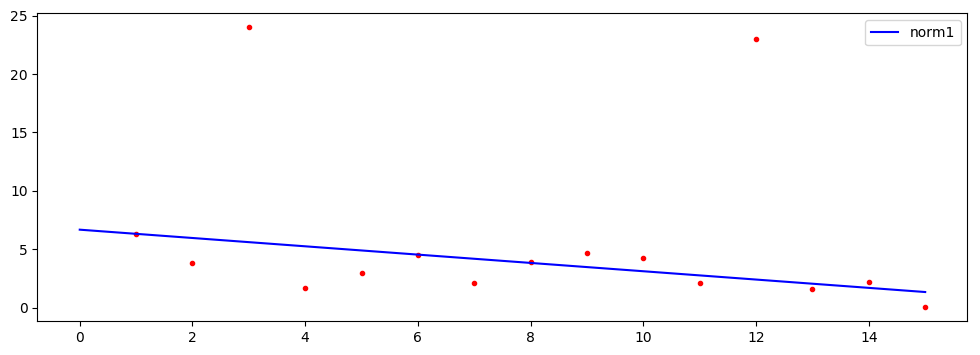

In [11]:
xfine_L1 = linspace(0,15,npts)
ffine_L1 = ones(npts)
for j = 1:k
    ffine_L1 = [ffine_L1.*xfine_L1 ones(npts)] 
end
yfine_L1 = ffine_L1 * uopt_L1

figure(figsize=(12,4))
plot( x, y, "r.")
plot( xfine_L1, yfine_L1, "b-",label="norm1")
legend();

The $\ell_1$ norm model fits the data much better. The $\ell_2$ norm penalizes the model much severly for the outliers since the distance to them is squared, whereas the $\ell_1$ norm is just adding the absolute values. This results in less shifting of the line towards the outlier in the $\ell_1$ norm case and hence the better results

__c) Another approach is to use an __$\ell_2$__ penalty for points that are close to the line but an__ $\ell_1$ __penalty
for points that are far away. Specifically, we’ll use something called the Huber loss, defined as__:

$$\phi(x) = \begin{cases} 
      x^2  & if -M \leq x \leq M \\
      2M|x| - M^2  & otherwise \\
   \end{cases}$$

__Here, M is a parameter that determines where
the quadratic function transitions to a linear
function. The plot on the right shows what
the Huber loss function looks like for M = 1.
The formula above is simple, but not in a form that is useful for us. As it turns out, we can
evaluate the Huber loss function at any point $x$ by solving the following convex QP instead__:

$$\phi(x) = 
\begin{cases}
\begin{equation*}
\begin{aligned}
& \underset{v,w}{\text{minimize}}
& & w^2 + 2Mv \\
& \text{subject to}:
& & |x| \leq w + v \\
& & & v \geq 0, w \leq M.
\end{aligned}
\end{equation*}
\end{cases}$$

__Verify this fact by solving the above QP (with M = 1) for many values of $x$ in the interval
$−3 ≤ x ≤ 3$ and reproducing the plot above. Finally, find the best linear fit to our data using a
Huber loss with $M = 1$ and produce a plot showing your fit. The cost function is:__

$$
Huber\space Loss : \sum_{i=1}^{15} \phi(y_i - ax_i -b)
$$

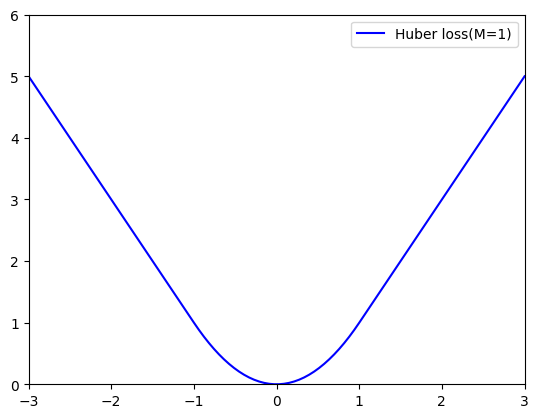

In [12]:
M = 1
X = linspace(-3,3,npts)
Y = zeros(1,100)
for (i,pt) in  enumerate(X)
    m = Model(solver=GurobiSolver(OutputFlag=0))

    @variable(m, v >= 0)
    @variable(m, w <= M)
    @constraint(m, abs(pt) <= w + v)
    @objective(m, Min, w^2 + 2M*v)
    solve(m)
    Y[i] = getobjectivevalue(m)
end

plot(X, Y', "b-", label="Huber loss(M=1)")
xlim(-3,3)
ylim(0,6)
legend();

The plot for different values from interval $[-3,3]$ is as given in the question

In [13]:
m = Model(solver=GurobiSolver(OutputFlag=0))

@variable(m, uopt_huber[1:k+1])
@variable(m, v[1:15] >= 0)
@variable(m, w[1:15] <= M)

@constraint(m, abs_array(y - A*uopt_huber) .<= w + v)

@objective(m, Min, sum(w.^2 + 2M*v))
status = solve(m)
uopt_Huber = getvalue(uopt_huber)
println(status)
println("L2 Error: ", norm(y-A*uopt_Huber)," Objective Value: ",
    getobjectivevalue(m),", Parameters learnt: ", uopt_Huber)

Optimal
L2 Error: 28.526155756854973 Objective Value: 95.49973754752351, Parameters learnt: [-0.281108,5.73812]


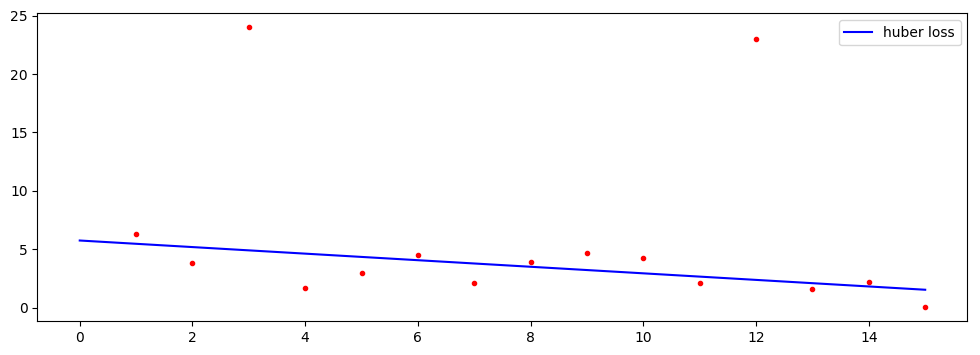

In [14]:
xfine_huber = linspace(0,15,npts)
ffine_huber = ones(npts)
for j = 1:k
    ffine_huber = [ffine_huber.*xfine_huber ones(npts)] 
end
yfine_huber = ffine_huber * uopt_Huber

figure(figsize=(12,4))
plot( x, y, "r.")
plot( xfine_huber, yfine_huber, "b-",label="huber loss")
legend();